# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Andrea Sala - Settembre 2020</span>
# <span style="color:darkgreen">  Esercitazione 6</span>

Il codice simula il modello di Ising monodimensionale. Il modello di Ising è un modello statistico per descrivere un sistema finito di $N$ spin con hamiltoniana 
$$ H = -J\sum_{i=1}^N s_i s_{i+1} -\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1})$$
con $s_i=\pm 1$ e $s_{N+1}=s_1$, $J>0$ (modello ferromagnetico) e con $h$ campo magnetico esterno. <br/>
Il modello di Ising è risolvibile analiticamente, ovvero la sua funzione di partizione può essere ottenuta in modo esatto come somma di due termini
$$ Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N\ $$
$$ \lambda_{1,2} = e^{\beta J} \cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)\right]^{1/2} \quad\quad \beta=\frac{1}{k_B T} = \frac{1}{T}\ .$$

Lo scopo dell'esercitazione è calcolare alcune grandezze termodinamiche caratteristiche del modello quali:
- L'energia interna per particella $U/N$ ($h=0$) :$\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N} $
- La capacità termica $C$ ($h=0$): $\frac{C(N,T)}{N} = \frac{1}{N} k_B\beta^2 \left(\langle H^2 \rangle -\langle H \rangle^2 \right)$
- La magnetizzazione $M$ ($h\not=0$):
$M(N,T,h) =\left\langle \sum_{i=1,N}s_i \right\rangle$
- La suscettività magnetica $\chi$ con $h=0$:
$\chi(N,T) = \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle - \left\langle \sum_{i=1,N}s_i \right\rangle^2 \right] $



Dalle definizioni delle grandezze appena sopra si nota che esse possono essere estratte da simulazioni Monte Carlo, calcolando i valori medi dell'hamiltoniana e della somma degli spin e i loro quadrati. Data la particolarità del modello, si è poi potuto confrontare i risultati ottenuti con le curve analitiche (i risultati analitici non sono stati riportati esplicitamente). <br/>
L'evoluzione del sistema viene eseguita con due diversi algoritmi:
- L'**Algoritmo di Metropolis** propone di invertire il segno (*flip*) di uno a caso tra gli spin del sistema, calcola l'energia della nuova configurazione e di quella vecchia e si usa il peso di Boltzmann $e^{-\beta (E_{new} - E_{old})}$ come distribuzione di probabilità da campionare. Viene quindi accettata o rifiutata la mossa come al solito estraendo $r\in[0,1]$ e accettando solo se $r < \min \{1, e^{-\beta (E_{new}-E_{old})}\}$
- L'**Algoritmo di Gibbs** invece propone mosse che vengono sempre accettate, ma non lavora sul flipping degli spin, ma piuttosto sceglie uno spin a caso e gli assegna il valore +1 con probabilità $A = min(1, \frac{1}{1+e^{-\beta(energy_{down}-energy_{up})}})$, altrimenti viene assegnato il valore -1.

Il codice calcola ad ogni step i valori istantanei delle grandezze termodinamiche attraverso le funzioni `Move()` e `Measure()`, accumulando le stime per il data blocking con le funzioni `Accumulate()` e `Averages()`. Per le mie simulazioni ho scelto di dividere il codice in 100 blocchi di 10000 misure ciascuno. Ho inoltre aggiunto al codice la possibilità di ripartire da una configurazione preesistente alternativa alla partenza con spin generati casualmente: questa feature è importante quando si vuole equilibrare il sistema. 
La scelta del campionamento da usare (Metropolis o Gibbs), la temperatura del sistema, il numero di spin e il valore di campo magnetico vengono tutti letti in input dal file `input.dat`.

### Equilibrazione

Per estrarre dei valori delle grandezze termodinamiche, il codice necessita di una prima fase di equilibrazione. Questa è stata eseguita eseguendo il codice dapprima con generazione casuale degli spin, e successivamente attivando l'opzione di restart da un file di input. Di seguito riporto i grafici del processo di equlibrazione con campionamento di tipo Metropolis e $T=2.0$ : si osserva che dopo circa 80 blocchi i valori medi convergono. Ho scelto dunque questo numero di blocchi per equilibrare il sistema in tutte le simulazioni successive

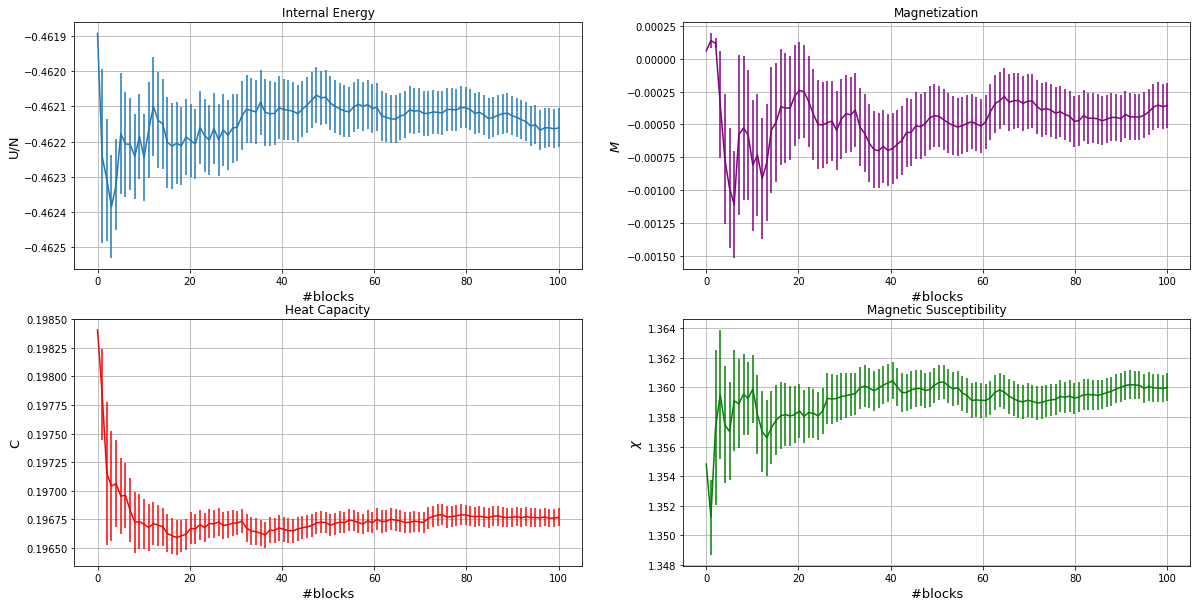

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

(Ene, errEne) = np.loadtxt('ISING_1D/Metropolis/Metro_equi.ene.0', usecols=(2,3), unpack=True)
(Heat, errHeat) = np.loadtxt('ISING_1D/Metropolis/Metro_equi.heat.0', usecols=(2,3), unpack=True)
(Mag, errMag) = np.loadtxt('ISING_1D/Metropolis/Metro_equi.mag.0', usecols=(2,3), unpack=True)
(Chi, errChi) = np.loadtxt('ISING_1D/Metropolis/Metro_equi.chi.0', usecols=(2,3), unpack=True)

x=np.linspace(0, len(Ene), len(Ene))

fig, axs = plt.subplots(2, 2, figsize=(20,10))
plt.title('Equilibration, T=2', fontsize=20)

axs[0,0].errorbar(x, Ene, yerr=errEne)
axs[0,0].set_ylabel('U/N', fontsize=13)
axs[0,0].set_title('Internal Energy')

axs[1,0].errorbar(x, Heat, yerr=errHeat, color='red')
axs[1,0].set_ylabel('C', fontsize=13)
axs[1,0].set_title('Heat Capacity')

axs[0,1].errorbar(x, Mag, yerr=errMag, color='purple')
axs[0,1].set_ylabel('$M$', fontsize=13)
axs[0,1].set_title('Magnetization')

axs[1,1].errorbar(x, Chi, yerr=errChi, color='green')
axs[1,1].set_ylabel('$\chi$', fontsize=13)
axs[1,1].set_title('Magnetic Susceptibility')

for ax in axs.flat:
    ax.set_xlabel('#blocks', fontsize=13)
    ax.grid()

### Calcolo delle grandezze termodinamiche in funzione di T

Ho lanciato il codice a diversi valori di temperatura e di campo esterno per raccogliere i dati delle grandezze termodinamiche (salvate su file in modalità `Append`). Al termine di ogni run il valore medio dell'ultimo blocco viene salvato in output e di seguito sono plottati i grafici. Essi mostrano un accordo quasi perfetto tra simulazione e misure teoriche.

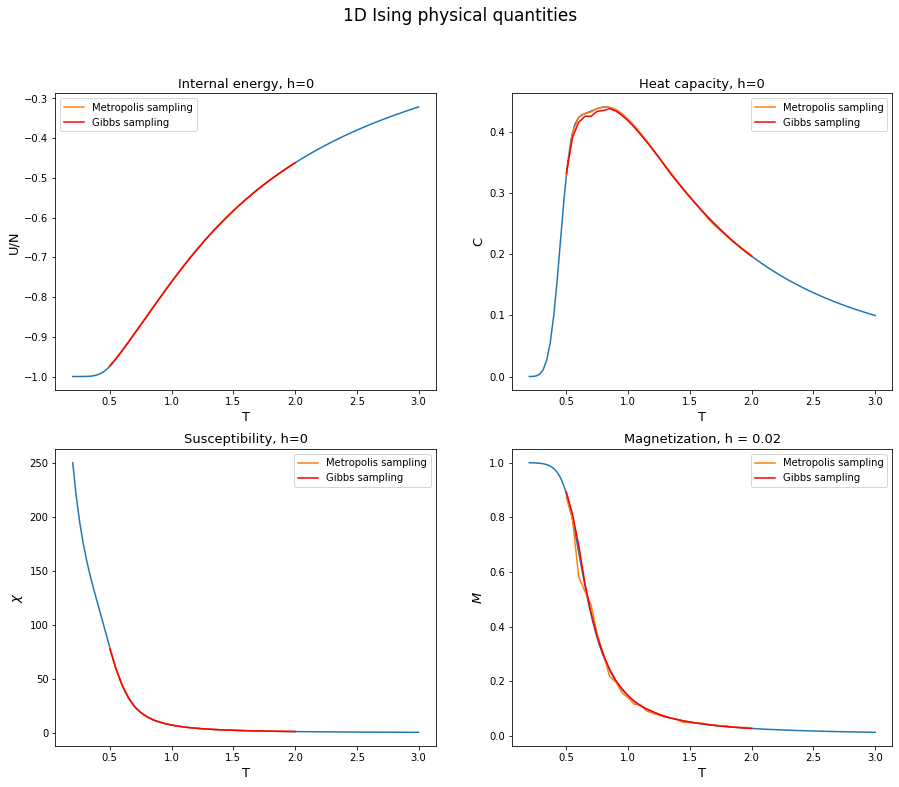

In [32]:
points=100
T = np.linspace(0.2,3.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

(temp, U_M, H_M,X_M) = np.loadtxt('ISING_1D/Metropolis/Metro_output_H0.dat', usecols=(0, 1, 2, 3), unpack=True)
M_M = np.loadtxt('ISING_1D/Metropolis/Metro_output_H2.dat', usecols=(1), unpack=True)

(U_G, H_G,X_G) = np.loadtxt('ISING_1D/Gibbs/Gibbs_output_H0.dat', usecols=(1, 2, 3), unpack=True)
M_G = np.loadtxt('ISING_1D/Gibbs/Gibbs_output_H2.dat', usecols=(1), unpack=True)

fig, axs = plt.subplots(2, 2, figsize=(15,12))

plt.suptitle('1D Ising physical quantities', fontsize=17)

#Energy

axs[0,0].plot(T, e)
axs[0,0].plot(temp, U_M, label = 'Metropolis sampling')
axs[0,0].plot(temp, U_G, label = 'Gibbs sampling', color='red')
axs[0,0].set_title('Internal energy, h=0', fontsize=13)
axs[0,0].set_ylabel('U/N', fontsize=13)

#Heat Capacity

heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

axs[0,1].plot(T, heat)
axs[0,1].plot(temp, H_M, label = 'Metropolis sampling')
axs[0,1].plot(temp, H_G, label = 'Gibbs sampling', color='red')
axs[0,1].set_title('Heat capacity, h=0', fontsize=13)
axs[0,1].set_ylabel('C', fontsize=13)

#Susceptivity

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

axs[1,0].plot(T, X)
axs[1,0].plot(temp, X_M, label = 'Metropolis sampling')
axs[1,0].plot(temp, X_G, label = 'Gibbs sampling', color='red')
axs[1,0].set_title('Susceptibility, h=0', fontsize=13)
axs[1,0].set_ylabel('$\chi$', fontsize=13)

h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

#Magnetization

axs[1,1].plot(T, M)
axs[1,1].plot(temp, M_M, label = 'Metropolis sampling')
axs[1,1].plot(temp, M_G,label = 'Gibbs sampling', color='red')
axs[1,1].set_title('Magnetization, h = 0.02', fontsize=13)
axs[1,1].set_ylabel('$M$', fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('T', fontsize=13)
    ax.legend(fontsize='medium')